<a href="https://colab.research.google.com/github/sandwrath/AspNetCore.Docs/blob/JamesNK-patch-2/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import the Libraries

In [4]:
import csv
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional

import matplotlib.pyplot as plt

import datetime
%load_ext tensorboard

In [ ]:
rm -rf ./logs/

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Hyper-Parameters

In [6]:
vocab_size = 5000 # make the top list of words (common words)
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary
training_portion = .7

# Populate List and Remove the Stopwords

In [7]:
articles = []
labels = []
i = 0

with open("/content/drive/MyDrive/ABSA/Classifier Data/sentences.csv", 'r',encoding='latin-1') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
      if(row[2] == 'PROBLEM DISCOVERY'):
        labels.append('BUG')
      if(row[2] == 'INFORMATION SEEKING'):
        labels.append('HELP') 
      if(row[2] == 'FEATURE REQUEST'):
        labels.append('REQUEST') 
      if(row[2] == 'INFORMATION GIVING'):
        labels.append('FEEDBACK')         
      if(row[2] == 'OTHER'):
        labels.append('OTHER')
      article = row[1]
      for word in STOPWORDS:
          token = ' ' + word + ' '
          article = article.replace(token, ' ')
          article = article.replace(' ', ' ')
      articles.append(article)
      # i = i+1
      # if i > 10000 :
      #   break;

In [ ]:
df = pd.DataFrame(articles, columns=["review"])
df.to_csv('/content/drive/MyDrive/ABSA/Classifier Data/processed_reviews.csv', index=False)
df = pd.DataFrame(labels,columns=["label"])
df.to_csv('/content/drive/MyDrive/ABSA/Classifier Data/processed_labels.csv', index=False)

# Create Training and Validation Set

In [8]:
print(len(labels))
print(len(articles))

451293
451293


In [9]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

In [ ]:
print("train Size:", train_size)
print("train articles : ",len(train_articles))
print("train lables: ", len(train_labels))
print("validation articles: " , len(validation_articles))
print("validation Lables: ", len(validation_labels))

train Size: 315905
train articles :  315905
train lables:  315905
validation articles:  135388
validation Lables:  135388


In [10]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

In [11]:
train_sequences = tokenizer.texts_to_sequences(train_articles)

In [12]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
print(set(labels))

{'HELP', 'FEEDBACK', 'REQUEST', 'OTHER', 'BUG'}


In [14]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [ ]:
label_tokenizer.word_index

{'bug': 2, 'feedback': 3, 'help': 5, 'other': 1, 'request': 4}

In [16]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 386,822
Trainable params: 386,822
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)


# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# ! rm -rf logs
# %tensorboard --logdir logs

In [ ]:
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
9873/9873 - 235s - loss: 0.3224 - accuracy: 0.8902 - val_loss: 0.4057 - val_accuracy: 0.8550
Epoch 2/10
9873/9873 - 225s - loss: 0.2756 - accuracy: 0.9024 - val_loss: 0.3900 - val_accuracy: 0.8610
Epoch 3/10
9873/9873 - 225s - loss: 0.2634 - accuracy: 0.9069 - val_loss: 0.3849 - val_accuracy: 0.8639
Epoch 4/10
9873/9873 - 225s - loss: 0.2556 - accuracy: 0.9094 - val_loss: 0.3780 - val_accuracy: 0.8654
Epoch 5/10
9873/9873 - 219s - loss: 0.2492 - accuracy: 0.9121 - val_loss: 0.3808 - val_accuracy: 0.8668
Epoch 6/10
9873/9873 - 219s - loss: 0.2450 - accuracy: 0.9133 - val_loss: 0.3774 - val_accuracy: 0.8671
Epoch 7/10
9873/9873 - 219s - loss: 0.2411 - accuracy: 0.9149 - val_loss: 0.3818 - val_accuracy: 0.8664
Epoch 8/10
9873/9873 - 222s - loss: 0.2378 - accuracy: 0.9160 - val_loss: 0.3801 - val_accuracy: 0.8664
Epoch 9/10
9873/9873 - 224s - loss: 0.2344 - accuracy: 0.9171 - val_loss: 0.3809 - val_accuracy: 0.8679
Epoch 10/10
9873/9873 - 225s - loss: 0.2317 - accuracy: 0.9182 -

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

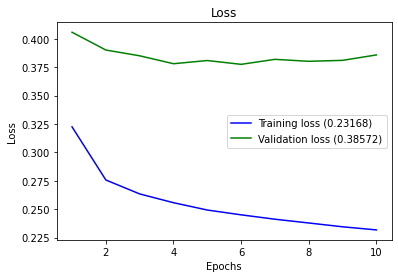

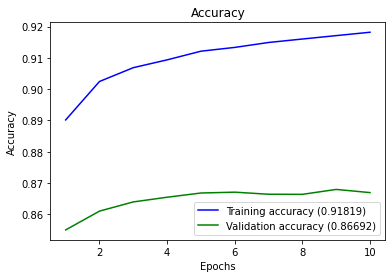

In [ ]:
plot_history(history)

In [17]:
txt = ["tnx"]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['other', 'bug', 'feedback', 'request', 'help'] 

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred) - 1])

[[0.16873191 0.16994089 0.16833286 0.16545008 0.16518502 0.16235922]]
1
other


In [18]:
model.save('/content/drive/MyDrive/ABSA/Classifier Data/classifier.m')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ABSA/Classifier Data/classifier.m/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ABSA/Classifier Data/classifier.m/assets


In [19]:
from tensorflow import keras
modelL = keras.models.load_model('/content/drive/MyDrive/ABSA/Classifier Data/classifier.m')

In [20]:
txt = ["Suryakumarsk Surya kumar.S" ,"tnx" ]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = modelL.predict(padded)
labels = ['other', 'bug', 'feedback', 'request', 'help'] 

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred) - 1] )

[[0.1671696  0.17053114 0.1704761  0.16635321 0.16328955 0.16218045]
 [0.16873191 0.16994089 0.16833286 0.16545008 0.16518502 0.16235922]]
1
other


In [21]:
from sklearn.metrics import confusion_matrix

pred = modelL.predict(validation_padded)


In [22]:
val_pred = []
for i in range(0,len(pred)):
  val_pred.append([np.argmax(pred[i])])


In [23]:
confusion = confusion_matrix(validation_label_seq, val_pred)
print('Confusion Matrix\n')
print(confusion)


Confusion Matrix

[[    0     0     0     0     0     0]
 [50228 51153   167    27  2836     1]
 [ 6632  4745    25     5   992     0]
 [ 6820  2365    12     1   453     1]
 [ 4381  1354    45     1   618     3]
 [ 1150  1235     5     1   131     1]]


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(validation_label_seq, val_pred)))


print('Micro Precision: {:.2f}'.format(precision_score(validation_label_seq, val_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(validation_label_seq, val_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(validation_label_seq, val_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(validation_label_seq, val_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(validation_label_seq, val_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(validation_label_seq, val_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(validation_label_seq, val_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(validation_label_seq, val_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(validation_label_seq, val_pred, average='weighted')))



Accuracy: 0.38

Micro Precision: 0.38
Micro Recall: 0.38
Micro F1-score: 0.38

Macro Precision: 0.21


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Recall: 0.10
Macro F1-score: 0.12

Weighted Precision: 0.67
Weighted Recall: 0.38
Weighted F1-score: 0.48


In [90]:
def TN_fun (x,y,m) :
  tn = 0
  for i in range(1,len(m)):
    if i == x :
      continue
    for j in range(0,len(m)-1):
      if j == y:
        continue
      tn += m[i][j]
  return tn;

def FP_fun (x,y,m):
  fp = 0
  for j in range(0,len(m)-1):
    if j == y:
      continue
    fp += m[x][j]
  return fp

def FN_fun (x,y,m):
  fn = 0
  for i in range(1,len(m)):
    if i == x:
      continue
    fn += m[i][y]
  return fn

def Precision_fun(x,y,m):
  TP = m[x][y]
  FP = FP_fun(x,y,m)
  return TP / (TP + FP)

def Recall_fun(x,y,m):
  TP = m[x][y]
  FN = FN_fun(x,y,m)
  return TP / (TP + FN)

def F1_fun(x,y,m):
  p = Precision_fun(x,y,m)
  r = Recall_fun(x,y,m)
  f1 = 2 * (p*r)/(p+r)
  return f1
  

In [93]:
#the Other Class
Precision = Precision_fun(1,0,confusion)
Recall = Recall_fun(1,0,confusion)
F1 = F1_fun(1,0,confusion)

print("Other class Precision: ",Precision)
print("Other class Recall: ",Recall)
print("Other class F1: ",F1)



Other class Precision:  0.481060424667899
Other class Recall:  0.7257227897299562
Other class F1:  0.5785902708182143


In [94]:
#The Bug Class
Precision = Precision_fun(2,1,confusion)
Recall = Recall_fun(2,1,confusion)
F1 = F1_fun(2,1,confusion)

print("Bug class Precision: ",Precision)
print("Bug class Recall: ",Recall)
print("Bug class F1: ",F1)

Bug class Precision:  0.38269215259295103
Bug class Recall:  0.07797607309537895
Bug class F1:  0.12955454533043917


In [96]:
#The Feedback Class
Precision = Precision_fun(3,2,confusion)
Recall = Recall_fun(3,2,confusion)
F1 = F1_fun(3,2,confusion)

print("Bug class Precision: ",Precision)
print("Bug class Recall: ",Recall)
print("Bug class F1: ",F1)


Bug class Precision:  0.0012433944668946222
Bug class Recall:  0.047244094488188976
Bug class F1:  0.0024230186774356383


In [98]:
#The Request Class
Precision = Precision_fun(4,3,confusion)
Recall = Recall_fun(4,3,confusion)
F1 = F1_fun(4,3,confusion)
print("Bug class Precision: ",Precision)
print("Bug class Recall: ",Recall)
print("Bug class F1: ",F1)


Bug class Precision:  0.0001562744178777934
Bug class Recall:  0.02857142857142857
Bug class F1:  0.00031084861672365556


In [99]:
#The Help Class
Precision = Precision_fun(5,4,confusion)
Recall = Recall_fun(5,4,confusion)
F1 = F1_fun(5,4,confusion)

print("Bug class Precision: ",Precision)
print("Bug class Recall: ",Recall)
print("Bug class F1: ",F1)


Bug class Precision:  0.05194290245836638
Bug class Recall:  0.026043737574552684
Bug class F1:  0.03469279661016949
